### Import libraries

In [1]:
### Import thư viện
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.optim as optim
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from sklearn.metrics import f1_score, precision_score, recall_score, mean_squared_error, roc_auc_score


In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


### Prepareing data

In [3]:
def load_movielens_1m(folder_path = './ml-1m'):
    users_cols = ['user_id', 'gender', 'age', 'occupation', 'zip_code']
    users = pd.read_csv(
        folder_path + '/users.dat',
        sep='::', 
        header=None, 
        names=users_cols,
        engine='python',
        encoding='latin1'
    )

    movies_cols = ['movie_id', 'title', 'genres']
    movies = pd.read_csv(
        folder_path + '/movies.dat',
        sep='::', 
        header=None, 
        names=movies_cols,
        engine='python',
        encoding='latin1'
    )
    
    ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
    ratings = pd.read_csv(
        folder_path + '/ratings.dat',
        sep='::', 
        header=None, 
        names=ratings_cols,
        engine='python',
        encoding='latin1'
    )
    
    return users, movies, ratings

In [4]:
users, movies, ratings = load_movielens_1m("./ml-1m")

In [5]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [6]:
print(len(ratings[ratings["rating"] < 4])/len(ratings))

0.4248392086054015


### Preprocessing data, building features

In [7]:
def remap_and_save(users, movies, ratings, folder_path):
    # Reassign user_id, movie_id begin from 0
    users['STT'] = range(0, len(users))
    movies['STT'] = range(0, len(movies))

    # Create a mapping from user_id to STT
    user_map = dict(zip(users['user_id'], users['STT']))
    movie_map = dict(zip(movies['movie_id'], movies['STT']))

    # Update ratings with new STT
    ratings['user_STT'] = ratings['user_id'].map(user_map)
    ratings['movie_STT'] = ratings['movie_id'].map(movie_map)
    ratings = ratings.drop(columns=['user_id', 'movie_id'])
    ratings = ratings.rename(columns={'user_STT': 'user_id', 'movie_STT': 'movie_id'})

    # Remove the old id column from users and movies DataFrame
    users = users.drop(columns=['user_id'])
    movies = movies.drop(columns=['movie_id'])
    users = users.rename(columns={'STT': 'user_id'})
    movies = movies.rename(columns={'STT': 'movie_id'})

    # Save the processed DataFrames to CSV files
    users.to_csv(folder_path + '/processed_users.csv', index=False)
    movies.to_csv(folder_path + '/processed_movies.csv', index=False)
    ratings.to_csv(folder_path + '/processed_ratings.csv', index=False)

In [9]:
# Use processed data
folder_path = "./ml-1m"
remap_and_save(users, movies, ratings, folder_path)
users = pd.read_csv(folder_path + '/processed_users.csv')
movies = pd.read_csv(folder_path + '/processed_movies.csv')
ratings = pd.read_csv(folder_path + '/processed_ratings.csv')

In [ ]:
def add_temporal_features(ratings):
    ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
    ratings['day_of_week'] = ratings['timestamp'].dt.dayofweek
    ratings['hour'] = ratings['timestamp'].dt.hour
    ratings['time_of_day'] = pd.cut(ratings['hour'],
                                    bins=[0, 6, 12, 18, 24],
                                    labels=[0, 1, 2, 3],
                                    include_lowest=True)
    ratings['month'] = ratings['timestamp'].dt.month
    ratings['is_weekend'] = ratings['day_of_week'].isin([5, 6]).astype(int)
    ratings['season'] = pd.cut(ratings['month'],
                                    bins=[0, 3, 6, 9, 12],
                                    labels=[0,1,2,3])
    return ratings
ratings = add_temporal_features(ratings)

In [ ]:
ratings

,rating,timestamp,user_id,movie_id,day_of_week,hour,time_of_day,month,is_weekend,season
0,5,2000-12-31 22:12:40,0,1176,6,22,3,12,1,3
1,3,2000-12-31 22:35:09,0,655,6,22,3,12,1,3
2,3,2000-12-31 22:32:48,0,902,6,22,3,12,1,3
3,4,2000-12-31 22:04:35,0,3339,6,22,3,12,1,3
4,5,2001-01-06 23:38:11,0,2286,5,23,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
1000204,1,2000-04-26 02:35:41,6039,1075,2,2,0,4,0,1
1000205,5,2000-04-25 23:21:27,6039,1078,1,23,3,4,0,1
1000206,5,2000-04-25 23:19:06,6039,558,1,23,3,4,0,1
1000207,4,2000-04-26 02:20:48,6039,1080,2,2,0,4,0,1


In [ ]:
def preprocess_data(users, movies, ratings):
    # Convert categorical user features to one-hot encoding
    users['gender'] = users['gender'].map({'F': 0, 'M': 1})
    bins = [0, 18, 30, 45, 60, 200]
    labels = list(range(len(bins)-1))
    users['age'] = pd.cut(users['age'], bins=bins, labels=labels, right=False)
    users['age'] = users['age'].astype(int)
    users['occupation'] = users['occupation'].astype(int)
    
    users_processed = pd.get_dummies(users[['gender', 'age', 'occupation']])
    users_features = torch.FloatTensor(users_processed.values).to(device)

    genres = []
    for g in movies['genres'].values:
        genre_list = g.split('|')
        genres.extend(genre_list)
    unique_genres = sorted(list(set(genres)))
    
    genre_mapping = {genre: i for i, genre in enumerate(unique_genres)}
    movie_features = np.zeros((len(movies), len(unique_genres)))
    
    for i, g in enumerate(movies['genres'].values):
        for genre in g.split('|'):
            movie_features[i, genre_mapping[genre]] = 1
            
    movie_features = torch.FloatTensor(movie_features).to(device)
    
    # Chia dữ liệu
    train_ratings, test_ratings = train_test_split(
        ratings, test_size=0.2, random_state=42
    )
    
    return train_ratings, test_ratings, users_features, movie_features


In [ ]:
train_ratings, test_ratings, user_features, movie_features=preprocess_data(users, movies, ratings)

In [ ]:
train_ratings.shape, test_ratings.shape, user_features.shape, movie_features.shape

((800167, 10), (200042, 10), torch.Size([6040, 3]), torch.Size([3883, 18]))

In [ ]:
num_users = user_features.shape[0]
num_items = movie_features.shape[0]
num_contexts = ratings["time_of_day"].nunique()
print(num_users)

6040


In [ ]:
feature_matrix = torch.zeros((num_users + num_items + num_contexts, user_features.shape[1] + movie_features.shape[1]))
feature_matrix[:num_users, :user_features.shape[1]] = user_features
feature_matrix[num_users : num_users + num_items, user_features.shape[1]:] = movie_features

In [ ]:
num_features = feature_matrix.shape[1]
movie_features = movie_features.to(device)
user_features = user_features.to(device)
feature_matrix = feature_matrix.to(device)

### Building User-Item Graph

- Tạo đồ thị tương tác giữa users và items
- Xây dựng ma trận kề và thuộc tính cạnh
- Chia dữ liệu thành train/test

In [ ]:
def create_movie_sim_matrix(movie_features, threshold=0.95, num_samples=2500):
    """
    Tính Jaccard similarity giữa các phim bằng PyTorch trên GPU.
    Args:
        movie_features (Tensor): (num_movies, num_features), kiểu torch.bool hoặc torch.float
        threshold (float): ngưỡng tương đồng
        num_samples (int): số lượng cặp phim lấy ngẫu nhiên
    Returns:
        movie_pairs (Tensor): (num_samples, 2)
        sim_values (Tensor): (num_samples,)
    """
    movie_features = movie_features.to(device)

    # Tính tích chéo giữa các vector đặc trưng (số bit trùng nhau)
    intersection = torch.matmul(movie_features, movie_features.T)

    # Tổng số bit "1" mỗi phim (dùng để tính union)
    row_sums = movie_features.sum(dim=1).unsqueeze(1)
    unions = row_sums + row_sums.T - intersection

    # Jaccard similarity
    jaccard_sim = intersection / unions.clamp(min=1e-8)

    # Lấy upper triangle
    num_movies = movie_features.shape[0]
    row_idx, col_idx = torch.triu_indices(num_movies, num_movies, offset=1, device=device)

    sim_values = jaccard_sim[row_idx, col_idx]

    # Lọc theo threshold
    mask = sim_values > threshold
    filtered_row = row_idx[mask]
    filtered_col = col_idx[mask]
    filtered_sim = sim_values[mask]

    # Sampling nếu cần
    total = filtered_sim.shape[0]
    if total > num_samples:
        indices = torch.randperm(total, device=device)[:num_samples]
        filtered_row = filtered_row[indices]
        filtered_col = filtered_col[indices]
        filtered_sim = filtered_sim[indices]

    # Trả về cặp chỉ số dưới dạng torch.stack hoặc zip
    movie_pairs = torch.stack([filtered_row, filtered_col], dim=1)  # (num_edges, 2)

    return movie_pairs, filtered_sim

In [ ]:
def create_new_user_item_edge(ratings, movie_features=movie_features):
    """
    Tạo các cạnh user-movie mới dựa trên độ tương đồng giữa các phim.

    Args:
    - ratings (DataFrame): chứa các cột 'user_id', 'movie_id', 'rating'.
    - movie_features (Tensor, optional): tensor nhị phân (num_movies, num_genres) thể hiện đặc trưng của phim.

    Return:
    - new_edges_tensor (Tensor): tensor (2, N) trên GPU, mỗi cột là một cạnh (user_id, movie_id).
    - temp_ratings_tensor (Tensor): tensor (N,) trên GPU, là rating tạm thời được nội suy từ phim tương đồng.
    """
    movie_sim_edges, sim_values = create_movie_sim_matrix(movie_features)
    user_ids = users["user_id"]
    
    new_edges = []
    temp_ratings = []
    max_edges = np.abs(len(ratings[ratings["rating"] < 4]) - len(ratings[ratings["rating"] >= 4]))
    
    for u in user_ids:
        user_rated_movies = ratings[ratings['user_id'] == u]['movie_id'].tolist()
        if len(user_rated_movies) == 0:
            continue
        for (movie1, movie2), sim_val in zip(movie_sim_edges, sim_values):
            movie1 = int(movie1.cpu())
            movie2 = int(movie2.cpu())
            if movie1 in user_rated_movies and movie2 not in user_rated_movies:
                user_rating_for_movie1 = ratings.loc[
                    (ratings['user_id'] == u) & (ratings['movie_id'] == movie1),
                    'rating'].values[0]
                if user_rating_for_movie1 >= 4:
                    continue
                new_rating = sim_val * user_rating_for_movie1
                new_edges.append([u, movie2])
                temp_ratings.append(new_rating)
    
    total_new_edges = len(new_edges)
    if total_new_edges > max_edges // 3:
        selected_indices = np.random.choice(total_new_edges, size=max_edges // 3, replace=False)
        new_edges = [new_edges[i] for i in selected_indices]
        temp_ratings = [temp_ratings[i] for i in selected_indices]
    
    new_edges_tensor = torch.tensor(new_edges, dtype=torch.long, device=device).t()
    temp_ratings_tensor = torch.tensor(temp_ratings, dtype=torch.float, device=device)
    return new_edges_tensor, temp_ratings_tensor

In [ ]:
def create_interaction_graph(ratings, features, movie_features = movie_features):
    """
    Tạo đồ thị tương tác từ dữ liệu người dùng, phim và context.

    Args:
    - ratings (DataFrame): chứa các cột 'user_id', 'movie_id', 'rating', 'time_of_day'.
    - features (Tensor): đặc trưng ban đầu của các node (user, movie, context), kích thước (num_nodes, num_features).
    - movie_features (Tensor, optional): đặc trưng nhị phân của phim (dùng cho các tác vụ khác, mặc định dùng biến toàn cục).

    Return:
    - Data: đối tượng torch_geometric.data.Data chứa:
        - x: đặc trưng của các node (Tensor).
        - edge_index: chỉ số cạnh theo định dạng COO (Tensor 2×E).
        - edge_attr: trọng số các cạnh (Tensor E).
    """
    features = features.to(device)
    
    user_ids = ratings['user_id'].values
    item_ids = ratings['movie_id'].values + num_users
    ratings_values = ratings['rating'].values

    edges = np.stack([
        np.concatenate([user_ids, item_ids]),
        np.concatenate([item_ids, user_ids])
    ])
    edge_index = torch.tensor(edges, dtype=torch.long).to(device)

    edge_attr = torch.tensor(
        np.concatenate([ratings_values, ratings_values]),
        dtype=torch.float
    ).to(device)

    # Tính node id cho context
    CONTEXT_OFFSET = num_users + num_items

    '''Tạo các cạnh nối tới context'''
    # Tạo các cạnh user ↔ context
    user_time_edges = ratings.groupby(['user_id', 'time_of_day'], observed=True)['rating'].mean().reset_index()
    user_time_edges.rename(columns={'rating': 'weight'}, inplace=True)
    user_time_edges = user_time_edges.dropna()
    print("User and context:", user_time_edges.shape)

    # Convert sang torch tensor
    user_ids = torch.tensor(user_time_edges['user_id'].values, dtype=torch.long)
    context_ids = torch.tensor(user_time_edges['time_of_day'].cat.codes.values + CONTEXT_OFFSET, dtype=torch.long)
    edge_weight_context = torch.tensor(user_time_edges['weight'].values, dtype=torch.float)
    edge_context = torch.stack([context_ids, user_ids], dim=0)

    # Nối vào edge_index và edge_attr
    edge_index = torch.cat([edge_index, edge_context.to(edge_index.device)], dim=1)
    edge_attr = torch.cat([edge_attr, edge_weight_context.to(edge_attr.device)], dim=0)

    # Tạo các cạnh movie ↔ context
    item_time_edges = ratings.groupby(['movie_id', 'time_of_day'], observed=True)['rating'].mean().reset_index()
    item_time_edges.rename(columns={'rating': 'weight'}, inplace=True)
    item_time_edges = item_time_edges.dropna()
    print("Item and context:", item_time_edges.shape)

    # Convert sang torch tensor
    item_ids = torch.tensor(item_time_edges['movie_id'].values, dtype=torch.long)
    context_ids = torch.tensor(item_time_edges['time_of_day'].cat.codes.values + CONTEXT_OFFSET, dtype=torch.long)
    edge_weight_item_context = torch.tensor(item_time_edges['weight'].values, dtype=torch.float)
    edge_item_context = torch.stack([context_ids, item_ids], dim=0)

    # Nối vào edge_index và edge_attr
    edge_index = torch.cat([edge_index, edge_item_context.to(edge_index.device)], dim=1)
    edge_attr = torch.cat([edge_attr, edge_weight_item_context.to(edge_attr.device)], dim=0)

    return Data(x=features, edge_index=edge_index, edge_attr=edge_attr)


In [ ]:
def create_interaction_graph_extra(ratings, features, movie_features=movie_features, users = users, user_features=user_features):
    """
    Tạo đồ thị tương tác từ dữ liệu người dùng, phim và context.

    Args:
    - ratings (DataFrame): chứa các cột 'user_id', 'movie_id', 'rating', 'time_of_day'.
    - features (Tensor): đặc trưng ban đầu của các node (user, movie, context), kích thước (num_nodes, num_features).
    - movie_features (Tensor, optional): đặc trưng nhị phân của phim (dùng cho các tác vụ khác, mặc định dùng biến toàn cục).

    Return:
    - Data: đối tượng torch_geometric.data.Data chứa:
        - x: đặc trưng của các node (Tensor).
        - edge_index: chỉ số cạnh theo định dạng COO (Tensor 2×E).
        - edge_attr: trọng số các cạnh (Tensor E).
    """
    features = features.to(device)
    
    user_ids = ratings['user_id'].values
    item_ids = ratings['movie_id'].values + num_users
    ratings_values = ratings['rating'].values

    # Nối
    edges = np.stack([
        np.concatenate([user_ids, item_ids]),
        np.concatenate([item_ids, user_ids])
    ])
    edge_index = torch.tensor(edges, dtype=torch.long).to(device)

    edge_attr = torch.tensor(
        np.concatenate([ratings_values, ratings_values]),
        dtype=torch.float
    ).to(device)
    
    # Tạo thêm data
    new_edges_tensor, temp_ratings_tensor = create_new_user_item_edge(ratings)
    print(new_edges_tensor.shape)
    edge_index = torch.cat([edge_index, new_edges_tensor.to(edge_index.device)], dim=1)
    edge_attr = torch.cat([edge_attr, temp_ratings_tensor.to(edge_attr.device)], dim=0)

    # Tính node id cho context
    CONTEXT_OFFSET = num_users + num_items

    '''Tạo các cạnh nối tới context'''
    # Tạo các cạnh user ↔ context
    user_time_edges = ratings.groupby(['user_id', 'time_of_day'], observed=True)['rating'].mean().reset_index()
    user_time_edges.rename(columns={'rating': 'weight'}, inplace=True)
    user_time_edges = user_time_edges.dropna()
    print("User and context:", user_time_edges.shape)

    # Convert sang torch tensor
    user_ids = torch.tensor(user_time_edges['user_id'].values, dtype=torch.long)
    context_ids = torch.tensor(user_time_edges['time_of_day'].cat.codes.values + CONTEXT_OFFSET, dtype=torch.long)
    edge_weight_context = torch.tensor(user_time_edges['weight'].values, dtype=torch.float)
    edge_context = torch.stack([context_ids, user_ids], dim=0)

    # Nối vào edge_index và edge_attr
    edge_index = torch.cat([edge_index, edge_context.to(edge_index.device)], dim=1)
    edge_attr = torch.cat([edge_attr, edge_weight_context.to(edge_attr.device)], dim=0)

    # Tạo các cạnh movie ↔ context
    item_time_edges = ratings.groupby(['movie_id', 'time_of_day'], observed=True)['rating'].mean().reset_index()
    item_time_edges.rename(columns={'rating': 'weight'}, inplace=True)
    item_time_edges = item_time_edges.dropna()
    print("Item and context:", item_time_edges.shape)

    # Convert sang torch tensor
    item_ids = torch.tensor(item_time_edges['movie_id'].values, dtype=torch.long)
    context_ids = torch.tensor(item_time_edges['time_of_day'].cat.codes.values + CONTEXT_OFFSET, dtype=torch.long)
    edge_weight_item_context = torch.tensor(item_time_edges['weight'].values, dtype=torch.float)
    edge_item_context = torch.stack([context_ids, item_ids], dim=0)

    # Nối vào edge_index và edge_attr
    edge_index = torch.cat([edge_index, edge_item_context.to(edge_index.device)], dim=1)
    edge_attr = torch.cat([edge_attr, edge_weight_item_context.to(edge_attr.device)], dim=0)
    
    return Data(x=features, edge_index=edge_index, edge_attr=edge_attr)

In [ ]:
def prepare_graph_data(train_ratings, test_ratings, feature_matrix):
    train_data_extra = create_interaction_graph_extra(train_ratings, feature_matrix)
    train_data = create_interaction_graph(train_ratings, feature_matrix)
    test_data = create_interaction_graph(test_ratings, feature_matrix)

    return train_data_extra, train_data, test_data

In [ ]:
user_features, movie_features

(tensor([[ 0.,  0., 10.],
         [ 1.,  3., 16.],
         [ 1.,  1., 15.],
         ...,
         [ 0.,  3.,  1.],
         [ 0.,  3.,  0.],
         [ 1.,  1.,  6.]], device='cuda:0'),
 tensor([[0., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]], device='cuda:0'))

In [ ]:
train_data_extra, train_data, test_data = prepare_graph_data(train_ratings, test_ratings, feature_matrix)
train_data_extra = train_data_extra.to(device)
train_data = train_data.to(device)
test_data = test_data.to(device)

train_loader_extra = DataLoader([train_data_extra], batch_size=8)
train_loader = DataLoader([train_data], batch_size=8)
test_loader = DataLoader([test_data], batch_size=8)

torch.Size([2, 40023])
User and context: (9715, 3)
Item and context: (13787, 3)
User and context: (9715, 3)
Item and context: (13787, 3)
User and context: (9216, 3)
Item and context: (12175, 3)


In [ ]:
print(f"edge_index max: {train_data.edge_index.max()}, num_nodes: {train_data.x.size(0)}")
print(f"edge_index min: {train_data.edge_index.min()}")

edge_index max: 9926, num_nodes: 9927
edge_index min: 0


In [ ]:
print(f"edge_index max: {test_data.edge_index.max()}, num_nodes: {test_data.x.size(0)}")
print(f"edge_index min: {test_data.edge_index.min()}")

edge_index max: 9926, num_nodes: 9927
edge_index min: 0


### Graph Convolutional Network

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        # Main path
        self.conv1 = GCNConv(num_features, hidden_channels)        
        self.conv2 = GCNConv(hidden_channels, hidden_channels // 2)
        self.conv3 = GCNConv(hidden_channels // 2, hidden_channels // 4)
        self.dropout = torch.nn.Dropout(0.4)
        # Thêm nhiều attention heads
        self.attention = torch.nn.MultiheadAttention(
            hidden_channels // 4, 
            num_heads=8,  # Tăng số lượng heads
            dropout=0.2   # Thêm dropout
        )

    def forward(self, x, edge_index, edge_attr):
        # Main path
        x = F.relu((self.conv1(x, edge_index, edge_weight=edge_attr)))
        x = self.dropout(x)
        x = F.relu((self.conv2(x, edge_index, edge_weight=edge_attr)))
        x = self.dropout(x)
        x = self.conv3(x, edge_index, edge_weight=edge_attr)
        # Apply attention
        x = x.unsqueeze(0)
        x, _ = self.attention(x, x, x)
        x = x.squeeze(0)
        return x
        

### Training

In [ ]:
def train(model, train_loader, optimizer, mse_criterion, mae_criterion, smooth1_criterion):
    model.train()
    mse_total = 0
    mae_total = 0
    smooth1_total = 0
    
    for batch in train_loader_extra:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        edge_index = batch.edge_index
        user_movie_mask = ((edge_index[0] < num_users) & (edge_index[1] >= num_users))
        filtered_edge_index = edge_index[:, user_movie_mask]
        filtered_edge_attr = batch.edge_attr[user_movie_mask]
        
        # Tính prediction và giới hạn trong khoảng [1;5]
        pred = torch.sum(out[filtered_edge_index[0]] * out[filtered_edge_index[1]], dim=1)
        pred = torch.clamp(pred, min=1.0, max=5.0)  # Giới hạn prediction

        mse_loss = mse_criterion(pred, filtered_edge_attr)
        mae_loss = mae_criterion(pred, filtered_edge_attr)
        smooth1_loss = smooth1_criterion(pred, filtered_edge_attr)
        
        mse_loss.backward()
        optimizer.step()
        mse_total += mse_loss.item()
        mae_total += mae_loss.item()
        smooth1_total += smooth1_loss.item()

    n = len(train_loader)
    return mse_total / n, mae_total / n, smooth1_total / n

def test(model, test_loader, mse_criterion, mae_criterion, smooth1_criterion):
    model.eval()
    mse_total = 0
    mae_total = 0
    smooth1_total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            
            out = model(batch.x, batch.edge_index, batch.edge_attr)
            edge_index = batch.edge_index
            edge_attr = batch.edge_attr
            
            user_movie_mask = ((edge_index[0] < num_users) & (edge_index[1] >= num_users))
            filtered_edge_index = edge_index[:, user_movie_mask]
            filtered_edge_attr = edge_attr[user_movie_mask]
            
            pred = (out[filtered_edge_index[0]] * out[filtered_edge_index[1]]).sum(dim=1)
            pred = torch.clamp(pred, min=1.0, max=5.0)  # Giới hạn prediction
            
            mse_loss = mse_criterion(pred, filtered_edge_attr)
            mae_loss = mae_criterion(pred, filtered_edge_attr)
            smooth1_loss = smooth1_criterion(pred, filtered_edge_attr)
            mse_total += mse_loss.item()
            mae_total += mae_loss.item()
            smooth1_total += smooth1_loss.item()
    n = len(test_loader)
    return mse_total / n, mae_total / n, smooth1_total / n

In [ ]:
hidden_channels = 256
model = GCN(num_features=feature_matrix.shape[1], hidden_channels=hidden_channels).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0004, weight_decay=1e-5)
mse_criterion = torch.nn.MSELoss()
mae_criterion = torch.nn.L1Loss()
smooth1_criterion = torch.nn.SmoothL1Loss()

train_mse_losses = []
train_mae_losses = []
train_smooth1_losses = []
test_mse_losses = []
test_mae_losses = []
test_smooth1_losses = []
num_epochs = 600

for epoch in range(num_epochs):
    train_mse, train_mae, train_smooth1 = train(model, train_loader_extra, optimizer, mse_criterion, mae_criterion, smooth1_criterion)
    test_mse, test_mae, test_smooth1 = test(model, test_loader, mse_criterion, mae_criterion, smooth1_criterion)

    train_mse_losses.append(train_mse)
    train_mae_losses.append(train_mae)
    train_smooth1_losses.append(train_smooth1)
    test_mse_losses.append(test_mse)
    test_mae_losses.append(test_mae)
    test_smooth1_losses.append(test_smooth1)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}")
        print(f"MSE: Train: {train_mse:.4f}, Test: {test_mse:.4f}")
        print(f"MAE: Train: {train_mae:.4f}, Test: {test_mae:.4f}")
        print(f"SmoothL1: Train: {train_smooth1:.4f}, Test: {test_smooth1:.4f}")

Epoch 10
MSE: Train: 2.5675, Test: 2.1199
MAE: Train: 1.2684, Test: 1.1349
SmoothL1: Train: 0.8696, Test: 0.7488
Epoch 20
MSE: Train: 2.9288, Test: 2.9095
MAE: Train: 1.3382, Test: 1.3328
SmoothL1: Train: 0.9532, Test: 0.9490
Epoch 30
MSE: Train: 2.8288, Test: 2.7227
MAE: Train: 1.3149, Test: 1.2855
SmoothL1: Train: 0.9296, Test: 0.9031
Epoch 40
MSE: Train: 2.4405, Test: 2.1078
MAE: Train: 1.2213, Test: 1.1298
SmoothL1: Train: 0.8335, Test: 0.7450
Epoch 50
MSE: Train: 2.4604, Test: 2.0967
MAE: Train: 1.2360, Test: 1.1349
SmoothL1: Train: 0.8412, Test: 0.7445
Epoch 60
MSE: Train: 2.3981, Test: 2.1060
MAE: Train: 1.2083, Test: 1.1262
SmoothL1: Train: 0.8218, Test: 0.7438
Epoch 70
MSE: Train: 2.3491, Test: 2.0559
MAE: Train: 1.2013, Test: 1.1205
SmoothL1: Train: 0.8107, Test: 0.7326
Epoch 80
MSE: Train: 2.3202, Test: 2.0430
MAE: Train: 1.1913, Test: 1.1116
SmoothL1: Train: 0.8026, Test: 0.7276
Epoch 90
MSE: Train: 2.2710, Test: 2.0249
MAE: Train: 1.1786, Test: 1.1082
SmoothL1: Train: 0.78

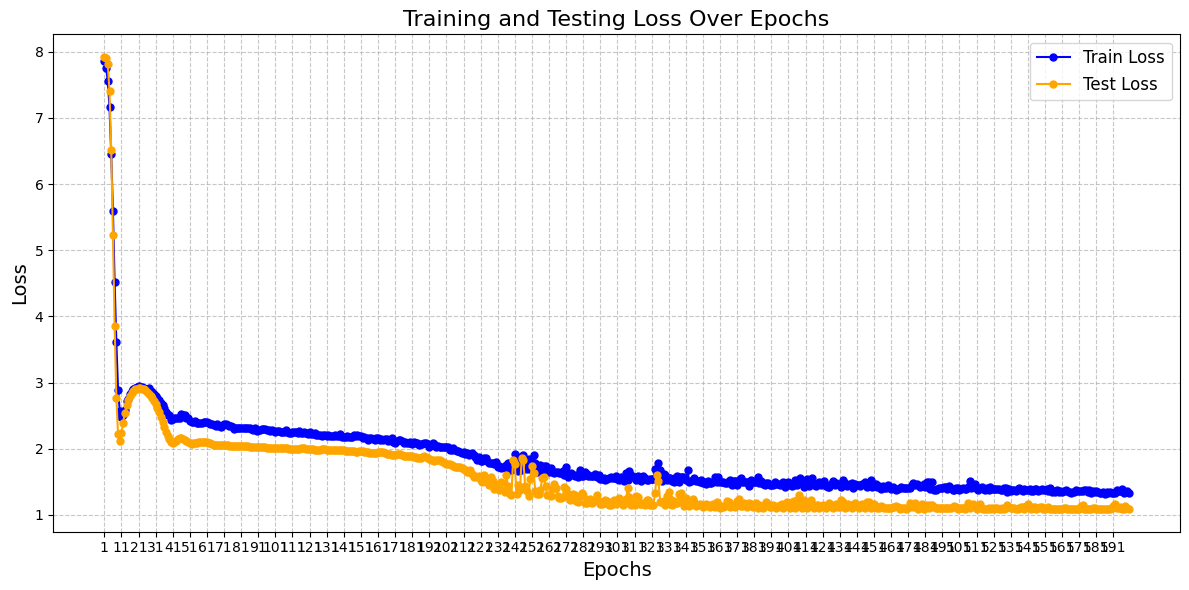

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_epochs + 1), train_mse_losses, label='Train Loss', color='blue', marker='o', markersize=5, linestyle='-')
plt.plot(range(1, num_epochs + 1), test_mse_losses, label='Test Loss', color='orange', marker='o', markersize=5, linestyle='-')
plt.title('Training and Testing Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(range(1, num_epochs + 1, 10))
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, data_loader, threshold = 3):
    model.eval()
    true_ratings = []
    pred_ratings = []

    with torch.no_grad():
        for data in data_loader:
            edge_index = data.edge_index
            edge_attr = data.edge_attr
            out = model(data.x, edge_index, edge_attr)

            # Lọc các cạnh user-movie trước khi tính toán
            user_movie_mask = ((edge_index[0] < num_users) & (edge_index[1] >= num_users))
            edge_index = edge_index[:, user_movie_mask]
            edge_attr = edge_attr[user_movie_mask]
            source_embeddings = out[edge_index[0]]
            target_embeddings = out[edge_index[1]]
            edge_scores = (source_embeddings * target_embeddings).sum(dim=1)
            edge_scores = torch.clamp(edge_scores, min=1.0, max=5.0)
            # edge_scores = torch.round(edge_scores)

            true_ratings.extend(edge_attr.cpu().numpy())
            pred_ratings.extend(edge_scores.cpu().numpy())

    true_ratings = np.array(true_ratings)
    pred_ratings = np.array(pred_ratings)

    true_binary = (true_ratings >= threshold).astype(int)
    pred_binary = (pred_ratings >= threshold).astype(int)

    precision = precision_score(true_binary, pred_binary)
    recall = recall_score(true_binary, pred_binary)
    f1 = f1_score(true_binary, pred_binary)
    roc_auc = roc_auc_score(true_binary, pred_ratings)
    mask_5 = (true_ratings == 5)
    rmse_5 = np.sqrt(mean_squared_error(true_ratings[mask_5], pred_ratings[mask_5]))

    ### ===> AUC TÍNH THEO RANKING NHƯ BÀI BÁO
    # Sắp xếp theo dự đoán
    sorted_indices = np.argsort(pred_ratings)  # ascending
    sorted_true = true_binary[sorted_indices]

    M = np.sum(sorted_true)   # số positive
    N = len(sorted_true) - M  # số negative

    if M == 0 or N == 0:
        auc_custom = float('nan')  # Tránh chia cho 0
    else:
        positive_ranks = np.where(sorted_true == 1)[0] + 1  # +1 vì rank bắt đầu từ 1
        auc_custom = (np.sum(positive_ranks) - M * (M + 1) / 2) / (M * N)

    return {
        # 'Accuracy on 5 ratings' : accuracy_5,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC (ranking)': auc_custom,
        'RMSE on 5 ratings' : rmse_5
    }
for threshold in [3, 3.5]:
    print("Threshold = ", threshold)
    train_metrics = evaluate_model(model, train_loader, threshold)
    print("Train Metrics:")
    for metric, value in train_metrics.items():
        print(f"{metric}: {value:.4f}")
    
    
    test_metrics = evaluate_model(model, test_loader, threshold)
    print("\nTest Metrics:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")
    print(f"Best MAE: {np.min(test_mae_losses):.4f}")
    print("=========================================")

Threshold =  3
Train Metrics:
Precision: 0.8472
Recall: 0.9773
F1-Score: 0.9076
AUC-ROC (ranking): 0.7126
RMSE on 5 ratings: 1.2128

Test Metrics:
Precision: 0.8470
Recall: 0.9773
F1-Score: 0.9075
AUC-ROC (ranking): 0.7085
RMSE on 5 ratings: 1.2390
Best MAE: 0.8390
Threshold =  3.5
Train Metrics:
Precision: 0.6889
Recall: 0.6987
F1-Score: 0.6937
AUC-ROC (ranking): 0.6889
RMSE on 5 ratings: 1.2128

Test Metrics:
Precision: 0.6889
Recall: 0.6884
F1-Score: 0.6886
AUC-ROC (ranking): 0.6838
RMSE on 5 ratings: 1.2390
Best MAE: 0.8390


In [ ]:
def evaluate_model(model, data_loader, k=10, threshold = 3):
    model.eval()
    metrics = {
        'MSE': 0.0,
        'MAE': 0.0,
        'SmoothL1': 0.0,
        'Precision@10': 0.0,
        'Recall@10': 0.0,
        'NDCG@10': 0.0
    }
    
    # Khởi tạo các criterion
    mse_criterion = torch.nn.MSELoss()
    mae_criterion = torch.nn.L1Loss()
    smooth1_criterion = torch.nn.SmoothL1Loss()
    
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            
            # Forward pass
            out = model(batch.x, batch.edge_index, batch.edge_attr)
            edge_index = batch.edge_index
            edge_attr = batch.edge_attr
            
            # Lọc chỉ cạnh user-movie
            user_movie_mask = ((edge_index[0] < num_users) & (edge_index[1] >= num_users))
            filtered_edge_index = edge_index[:, user_movie_mask]
            filtered_edge_attr = edge_attr[user_movie_mask]
            
            # Tính predictions
            pred = (out[filtered_edge_index[0]] * out[filtered_edge_index[1]]).sum(dim=1)
            pred = torch.clamp(pred, min=1.0, max=5.0)
            
            # Tính các loss
            metrics['MSE'] += mse_criterion(pred, filtered_edge_attr).item()
            metrics['MAE'] += mae_criterion(pred, filtered_edge_attr).item()
            metrics['SmoothL1'] += smooth1_criterion(pred, filtered_edge_attr).item()
            
            # Tính Precision@k, Recall@k và NDCG@k cho từng user
            users = filtered_edge_index[0].unique()
            for user in users:
                # Lấy các item của user này
                user_mask = (filtered_edge_index[0] == user)
                user_items = filtered_edge_index[1][user_mask]
                user_true = filtered_edge_attr[user_mask]
                user_pred = pred[user_mask]
                
                # Sắp xếp theo predicted score
                _, indices = torch.sort(user_pred, descending=True)
                
                # Lấy top k items
                top_k_indices = indices[:k]
                
                # Tính Precision@k
                relevant_items = (user_true[top_k_indices] >= threshold).sum()
                precision_at_k = relevant_items / k
                
                # Tính Recall@k
                total_relevant = (user_true >= threshold).sum()
                if total_relevant > 0:
                    recall_at_k = relevant_items / total_relevant
                else:
                    recall_at_k = torch.tensor(0.0)
                
                # Tính NDCG@k
                dcg = 0.0
                idcg = 0.0
                for i, idx in enumerate(top_k_indices):
                    rel = user_true[idx]
                    dcg += (2 ** rel - 1) / torch.log2(torch.tensor(i + 2))
                
                # Tính IDCG
                sorted_true, _ = torch.sort(user_true, descending=True)
                for i in range(min(k, len(sorted_true))):
                    rel = sorted_true[i]
                    idcg += (2 ** rel - 1) / torch.log2(torch.tensor(i + 2))
                
                ndcg = dcg / idcg if idcg > 0 else 0.0
                
                all_precisions.append(precision_at_k.item())
                all_recalls.append(recall_at_k.item())
                all_ndcgs.append(ndcg.item())
    
    # Tính trung bình các metrics
    n = len(data_loader)
    metrics['MSE'] /= n
    metrics['MAE'] /= n
    metrics['SmoothL1'] /= n
    metrics['Precision@10'] = np.mean(all_precisions)
    metrics['Recall@10'] = np.mean(all_recalls)
    metrics['NDCG@10'] = np.mean(all_ndcgs)
    
    return metrics

In [ ]:
# 3. Đánh giá trên tập validation
train_metrics = evaluate_model(model, train_loader_extra, k=10, threshold = 4)
print("Train Metrics:")
print(f"MSE: {train_metrics['MSE']:.4f}")
print(f"MAE: {train_metrics['MAE']:.4f}")
print(f"SmoothL1: {train_metrics['SmoothL1']:.4f}")
print(f"Precision@10: {train_metrics['Precision@10']:.4f}")
print(f"Recall@10: {train_metrics['Recall@10']:.4f}")
print(f"NDCG@10: {train_metrics['NDCG@10']:.4f}")

# 4. Đánh giá trên tập test
test_metrics = evaluate_model(model, test_loader, k=10, threshold = 4)
print("\nTest Metrics:")
print(f"MSE: {test_metrics['MSE']:.4f}")
print(f"MAE: {test_metrics['MAE']:.4f}")
print(f"SmoothL1: {test_metrics['SmoothL1']:.4f}")
print(f"Precision@10: {test_metrics['Precision@10']:.4f}")
print(f"Recall@10: {test_metrics['Recall@10']:.4f}")
print(f"NDCG@10: {test_metrics['NDCG@10']:.4f}")

Train Metrics:
MSE: 1.0834
MAE: 0.8377
SmoothL1: 0.4555
Precision@10: 0.8019
Recall@10: 0.2376
NDCG@10: 0.7154

Test Metrics:
MSE: 1.0894
MAE: 0.8411
SmoothL1: 0.4573
Precision@10: 0.6433
Recall@10: 0.6131
NDCG@10: 0.7831


In [ ]:
def get_recommendations(model, train_data, user_id, num_users, top_k=10):
    model.eval()
    with torch.no_grad():
        out = model(train_data.x.to(device), train_data.edge_index.to(device), train_data.edge_attr.to(device))
        user_embedding = out[user_id]
        movie_embeddings = out[num_users : num_users + num_items]
        movie_ids = torch.arange(num_users, num_users + num_items, device=device)

        scores = torch.matmul(movie_embeddings, user_embedding)

        rated_movies = set(ratings[ratings['user_id'] == user_id]['movie_id'].values + num_users)

        # Loại bỏ các phim đã đánh giá
        mask = torch.tensor([i not in rated_movies for i in movie_ids.tolist()], device=device)
        scores = scores[mask]
        movie_ids = movie_ids[mask]
        
        # Lấy top-k movie ID
        top_scores, top_indices = torch.topk(scores, top_k)
        recommended_movie_ids = movie_ids[top_indices]
        
        return recommended_movie_ids.cpu().tolist(), top_scores.cpu().tolist()

In [ ]:
recommended_ids, scores = get_recommendations(model, train_data, user_id=123, num_users=num_users, top_k=5)
print("Recommended Movie IDs:", recommended_ids)
print("Scores:", scores)

Recommended Movie IDs: [9354, 6297, 6887, 6940, 7218]
Scores: [4.9625244140625, 4.864109992980957, 4.862854957580566, 4.818385601043701, 4.8090009689331055]
